In [148]:
import pandas as pd

dT = 0.1  # 10 hz => 100ms

SIGMA_ALPHA_VALUE = 0.4
SIGMA_BETA_VALUE = 2.0
SIGMA_KAPPA_VALUE = 1.0

Q_VARIANCE_VALUE = 1


# file_path = 'con_vel_basic_log.csv'
# file_path = 'con_vel_beacon_freq_log.csv'
# file_path = 'con_vel_beacon_flag_AND_freq_log.csv'

# file_path = 'dyn_acc_basic_log.csv'
# file_path = 'dyn_acc_beacon_freq_log.csv'
file_path = 'dyn_acc_beacon_flag_AND_freq_log.csv'





# Einlesen der Datei

df_head = pd.read_csv(file_path, sep='\t', header=None, nrows=1, names=[

    'Zeit_Index',
    'Beacon0_Pos_X', 'Beacon0_Pos_Y',
    'Beacon1_Pos_X', 'Beacon1_Pos_Y',
    'Beacon2_Pos_X', 'Beacon2_Pos_Y',
    'GT_StartPos_X_Boat', 'GT_StartPos_Y_Boat' 
    
])


# Erst ab 2 Zeile lesen
df = pd.read_csv(file_path, sep='\t', header=None, skiprows=1, names=[
    'Zeit_Index',
    'X_GT', 'Y_GT',
    'Heading_GT', 'Heading', 'Heading_STD',
    'angle_GT_B0', 'angleDistorted_B0', 'STD_angle_B0',
    'angle_GT_B1', 'angleDistorted_B1', 'STD_angle_B1',
    'angle_GT_B2', 'angleDistorted_B2', 'STD_angle_B2',
    'Richtung_GT_X_B0', 'Richtung_GT_Y_B0',
    'Richtung_X_B0', 'Richtung_Y_B0', 'STD_Richtung_B0',
    'Richtung_GT_X_B1', 'Richtung_GT_Y_B1',
    'Richtung_X_B1', 'Richtung_Y_B1', 'STD_Richtung_B1',
    'Richtung_GT_X_B2', 'Richtung_GT_Y_B2',
    'Richtung_X_B2', 'Richtung_Y_B2', 'STD_Richtung_B2',
    'Entfernung_B0', 'EntfernungDistorted_B0', 'STD_Entfernung_B0',
    'Entfernung_B1', 'EntfernungDistorted_B1', 'STD_Entfernung_B1',
    'Entfernung_B2', 'EntfernungDistorted_B2', 'STD_Entfernung_B2'
])


#df_head

#print(df.head())
#df

In [149]:

"""
UKF mit Entfernung/Distanz.
"""

# Imports
import numpy as np
import matplotlib.pyplot as plt
from filterpy.common import Q_discrete_white_noise
from filterpy.kalman import UnscentedKalmanFilter as UKF
from filterpy.kalman import MerweScaledSigmaPoints
import math
from math import sin as sin
from math import cos as cos
import time
import pandas as pd


# --- ---- --- --- ---- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- 

# Konfigurationsvariablen

BEACON_POSITIONS = [
                    np.array([df_head['Beacon0_Pos_X'].values[0], df_head['Beacon0_Pos_Y'].values[0]]), 
                    np.array([df_head['Beacon1_Pos_X'].values[0], df_head['Beacon1_Pos_Y'].values[0]]), 
                    np.array([df_head['Beacon2_Pos_X'].values[0], df_head['Beacon2_Pos_Y'].values[0]])
                   ]





# --- ---- --- --- ---- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- 


def f_x(state, dt):
    """
    Zustandsübergangsfunktion.
    Da die Geschwindigkeit konstant ist und der Zustand nur die Position beinhaltet,
    hat diese Funktion einfach die Geschwindigkeit zur Position hinzugefügt.
    """
     
    x, y, vx, vy, ax, ay = state

    # Update position with current velocity and acceleration
    new_x = x + vx * dt + (ax * dt ** 2) / 2.0
    new_y = y + vy * dt + (ay * dt ** 2) / 2.0

    # Update velocity with current acceleration
    new_vx = vx + ax * dt
    new_vy = vy + ay * dt

    # Speed stays constant (no acceleration yet)
    new_ax = ax
    new_ay = ay

    return np.array([new_x, new_y, new_vx, new_vy, new_ax, new_ay])


def h_x(state):
    """
    Messfunktion.
    """

    # Position des Schiffs extrahieren
    # x, y, vx, vy, _, _ = state
    x, y = state[0], state[1]
    
    distances = []

    # Für alle Beacons 
    for beacon_pos in BEACON_POSITIONS:
        # Euklidische Distanz (Pythagoras): d = sqrt((x2 - x1)**2 + (y2 - y1) **2)
        distance = np.sqrt((beacon_pos[0] - x) ** 2 + (beacon_pos[1] - y) ** 2)
        
        distances.append(distance)
    
    # Bei drei Beacons: array([d1, d2, d3])
    return np.array(distances)


def init_ukf():
    """
    Initialisierung vom UKF.
    """

    sigmas = MerweScaledSigmaPoints(n=6, alpha=SIGMA_ALPHA_VALUE, beta=SIGMA_BETA_VALUE, kappa=SIGMA_KAPPA_VALUE)


    # Dim_z 3, da 3 (ein Vektor; 3 Elementen) separate Messungen von h_x zurück gegeben werden
    # ukf = UKF(dim_x=6, dim_z=3, fx=f_x, hx=h_x, dt=dT, points=sigmas)

    # Initialzustand aus dem ersten Logeintrag holen
    init_state = np.array([
        df['X_GT'].values[0], df['Y_GT'].values[0],  # x, y
        0, 0,  # vx, vy
        0, 0   # ax, ay
    ])
    
    ukf.x = init_state

    # print(init_state)
    
    ukf.Q = Q_discrete_white_noise(
        dim=2, dt=dT, var=Q_VARIANCE_VALUE, block_size=3, order_by_dim=False)
    
    return ukf


if __name__ == "__main__":

    # Speichere geschätzten Zustände und Kovarianzmatrizen
    uxs = []
    uPs = []

    # Init UKF.
    ukf = init_ukf()

    # Initial Zustand fix im Code vs. aus dem ersten Log
    # ukf.x = initial_state  #  passiert bereits in init_ukf-Funktion
    
    # Iteriere durch jede Zeile im Df
    for index, row in df.iterrows():
    
        # Standardabweichungen für die aktuelle Messung aus Spalte holen
        # Wichtig: Nochmal Division-Faktor anschauen
        std_b0 = row['STD_Entfernung_B0']
        std_b1 = row['STD_Entfernung_B1']
        std_b2 = row['STD_Entfernung_B2']
    
        # Zeige Std zwecks Korrektheit
        #print(std_b0, std_b1, std_b2)
        
        # Setze die Rauschmatrix R basierend auf den extrahierten Standardabweichungen immer neu
        ukf.R = np.diag([std_b0 ** 2, std_b1 ** 2, std_b2 ** 2])
    
        # Prüfe ob Std. in R-Matrix gesetzt werden
        # print(ukf.R)
        
        # Hole den aktuellen Messvektor z
        z = np.array([
            row['EntfernungDistorted_B0'], 
            row['EntfernungDistorted_B1'], 
            row['EntfernungDistorted_B2'], 
        ])
    
        # Check ob Daten korrekt eingelesen sind
        # print(z)
        
        # Vorhersage und Update mit dem aktuellen Messvektor
        ukf.predict()
        ukf.update(z)
    
        uxs.append(ukf.x.copy())
        uPs.append(ukf.P.copy())

    # Gefilterte Zustände [x, y, vx, vy, ax, ay]
    uxs = np.array(uxs)

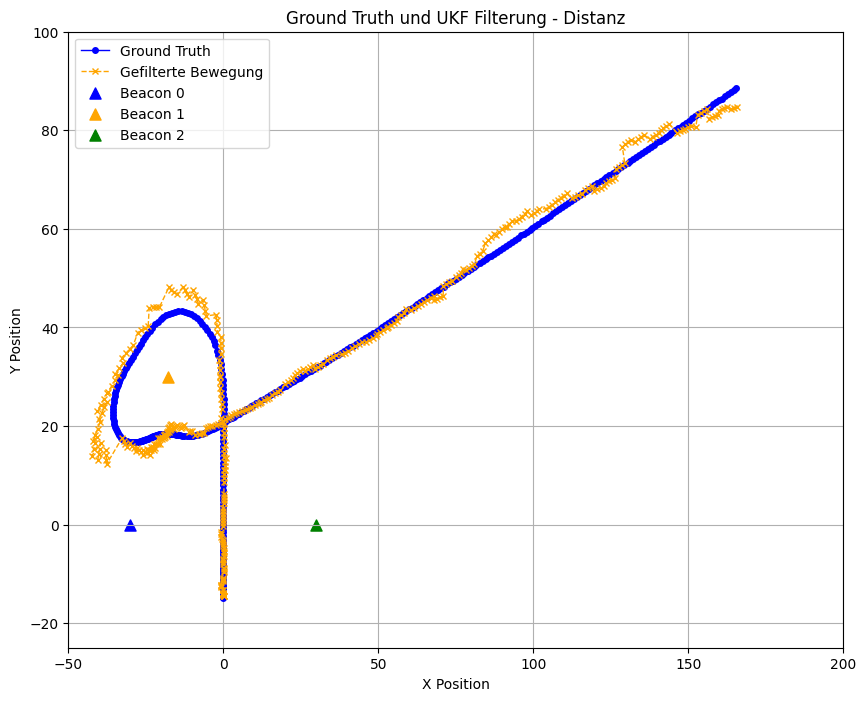

In [150]:
# Wichtig: Scatter statt Plot verwenden falls keine Verbindungslinien gezeichnet werden sollen!

def plotte_gt_and_estimate(gt_x, gt_y, x_esti, y_esti, beacons, title='Ground Truth und UKF Filterung - Distanz'):
    
    plt.figure(figsize=(10, 8))
    
    # Plot Ground Truth und geschätzte Position
    plt.plot(gt_x, gt_y, 'b-', label='Ground Truth', marker='o', markersize=4, linewidth=1)
    plt.plot(x_esti, y_esti, label='Gefilterte Bewegung', marker='x', markersize=4, linewidth=1, linestyle='--', color='orange')
    
    # Farben für die Beacons
    beacon_colors = ['blue', 'orange', 'green']
    
    # Beacons
    for i, beacon in enumerate(beacons):
        plt.scatter(beacon[0], beacon[1], s=64, color=beacon_colors[i], label=f'Beacon {i}', marker='^')

    
    plt.title(title)
    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    
    plt.xlim(-50, 200)
    plt.ylim(-25, 100)

    plt.legend()
    
    plt.grid(True)
    plt.show()


# BEACON_POSITIONS muss als Liste von [x, y] Koordinaten definiert sein
beacons_xy = [[beacon[0], beacon[1]] for beacon in BEACON_POSITIONS]


ux_val = [s[0] for s in uxs]
uy_val = [s[1] for s in uxs]


gt_x = df['X_GT'].tolist()
gt_y = df['Y_GT'].tolist()

plotte_gt_and_estimate(gt_x, gt_y, ux_val, uy_val, beacons_xy)

In [151]:
## Auswertungsfunktionen ##
## ==> RMSE für Strecke  
def calc_rmse(uxs, gt):
    """
    Berechne den Root-Square-Mean-Error zwischen den UKF-Schätzungen und dem GT.
    """

    if len(uxs) == 0:
        raise ValueError("Liste der Schätzung ist leer!")
    
    if len(uxs) != len(gt):
        raise ValueError("Schätzungen sind nicht gleich so lang wie GT.")

    # Position, erste beiden Spalten
    uxs_posi = uxs[:, :2]

    rmse = np.sqrt(((uxs_posi - gt) ** 2).mean(axis=0))

    return rmse


gt= df[['X_GT', 'Y_GT']].values

rmse = calc_rmse(uxs, gt)

print("RMSE (für x und y) ist:", rmse)

RMSE (für x und y) ist: [1.87169182 1.86983075]


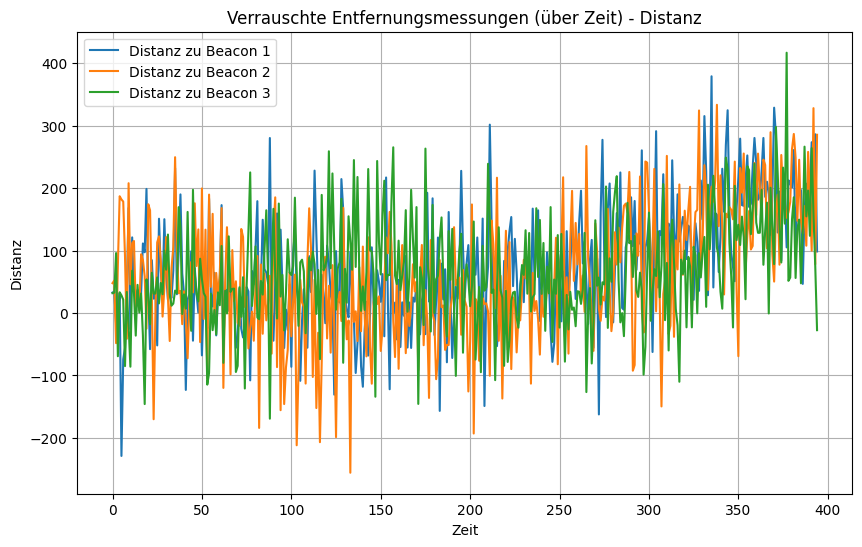

In [152]:

def plotte_noisy_distances(time_steps, noisy_distances):
    
    plt.figure(figsize=(10, 6))
    
    for i in range(noisy_distances.shape[1]):
        plt.plot(time_steps, noisy_distances[:, i], label=f'Distanz zu Beacon {i+1}')
    
    plt.title('Verrauschte Entfernungsmessungen (über Zeit) - Distanz')
    plt.xlabel('Zeit')
    plt.ylabel('Distanz')
    
    plt.legend()
    
    plt.grid(True)
    plt.show()



# df enthältverrauschten Distanzmessungen zu den Beacons in separaten Spalten
# dh.Zeit relativ zum Index der Datei
time_steps = df.index
noisy_distances = df[['EntfernungDistorted_B0', 'EntfernungDistorted_B1', 'EntfernungDistorted_B2']].values

plotte_noisy_distances(time_steps, noisy_distances)

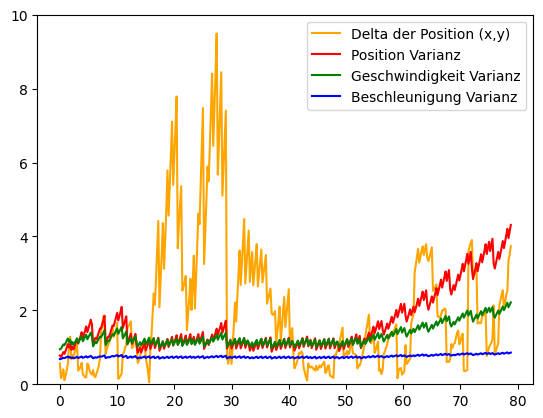

In [153]:

def calc_delta(uxs, gt):
    """
    Berechne Delta von geschätzten und GT (wahren Werten)
    """

    if len(uxs) == 0:
        raise ValueError("Liste der Schätzung ist leer!")
    
    if len(uxs) != len(gt):
        raise ValueError("Schätzungen sind nicht gleich so lang wie GT.")


    uxs_p = uxs[:, :2] # Positionen
    uxs_v = uxs[:, 2:4] # Geschwindigkeiten
    uxs_a = uxs[:, 4:6] # Beschleunigungen

    #
    #t = [(2 * i * dT) for i in range(len(uxs_p))]
    #plt.plot(t, delta_p, color = 'green')

    delta_x = (uxs[:, 0:1] - gt[:, 0:1]) 
    delta_y = (uxs[:, 1:2] - gt[:, 1:2])


    delta_p = np.sqrt((delta_x ** 2) + (delta_y ** 2))

    t = [(2 * i * dT) for i in range(len(delta_x))]

    #plt.plot(t, delta_x, color = 'green')
    #plt.plot(t, delta_y, color = 'blue')
    #plt.show()

    # Delta: zwischen geschätzten und Ground Truth (GT) Positionen
    plt.plot(t, delta_p, color = 'orange', label='Delta der Position (x,y)')

    # --- POSI.

    varianz_px = np.array([P[0,0] for P in uPs])
    varianz_py = np.array([P[1,1] for P in uPs])

    varianz_p = np.sqrt(varianz_px + varianz_py)

    plt.plot(t, varianz_p, color = 'red', label='Position Varianz')

    # --- VELO.

    varianz_vx = np.array([P[2,2] for P in uPs])
    varianz_vy = np.array([P[3,3] for P in uPs])

    varianz_v = np.sqrt(varianz_vx + varianz_vy)

    plt.plot(t, varianz_v, color = 'green', label='Geschwindigkeit Varianz')

    # --- ACC.

    varianz_ax = np.array([P[4,4] for P in uPs])
    varianz_ay = np.array([P[5,5] for P in uPs])

    varianz_a = np.sqrt(varianz_ax + varianz_ay)

    plt.plot(t, varianz_a, color = 'blue', label='Beschleunigung Varianz')


    plt.legend()

    # plt.xlim(-1, 20)
    plt.ylim(0, 10)



gt= df[['X_GT', 'Y_GT']].values
calc_delta(uxs, gt)


